# Project M2: Early Analysis & Insights
**Team:** B1 Team 15

**Name:** Tianqi Sun

## 1. Project Motivation & Problem Statement

**Refined Research Question:**
*"Quantifying Stylistic Evolution: Do the latent color structures identified via Unsupervised Learning (PCA & K-Means) exhibit a stationary distribution across 31 seasons, or can we detect measurable '"Structural Evolution ' in Bob Ross’s pigment usage?"*

**Context & Scope Change:**
While our original proposal outlined four potential research avenues, for this Milestone, I am focusing specifically on **Question 2 (Stylistic Stability)**.
Bob Ross is famous for his consistent style ("wet-on-wet" technique). However, visual consistency does not necessarily imply structural stagnation. By applying unsupervised learning techniques to the high-dimensional pigment data, we aim to uncover latent clusters of painting styles and analyze their distribution over time (Seasons 1-31).

This analysis will determine if Bob Ross's "formula" was truly static or if it evolved subtly over his decade-long career.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

In [12]:
df = pd.read_csv("bob_ross.csv")
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (403, 27)


,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


## 2. Data Preprocessing

The dataset contains metadata (Episode, Title) and binary indicators (0 or 1) for 18 specific pigments.
To perform unsupervised learning, we need to isolate the pigment features.

**Steps:**
1. Isolate the binary pigment columns.
2. Standardize the data. Even though the data is binary, standardization (Z-score normalization) is often recommended before PCA to ensure variance is treated equally, though for pure binary data, centered data is sufficient. Here we use StandardScaler to center the data for PCA.

In [13]:
pigment_cols = [
    'Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow',
    'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black',
    'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green',
    'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown',
    'Yellow_Ochre', 'Alizarin_Crimson'
]

existing_cols = [col for col in pigment_cols if col in df.columns]
print(f"Found {len(existing_cols)} pigment columns out of 18.")

X_raw = df[existing_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

Found 18 pigment columns out of 18.


## 3. Dimensionality Reduction (PCA)

Before clustering, we apply PCA to:
1.  Understand the effective dimensionality of the data.
2.  Visualize the high-dimensional binary vectors in 2D space.
3.  Check if there are continuous gradients in the painting styles.

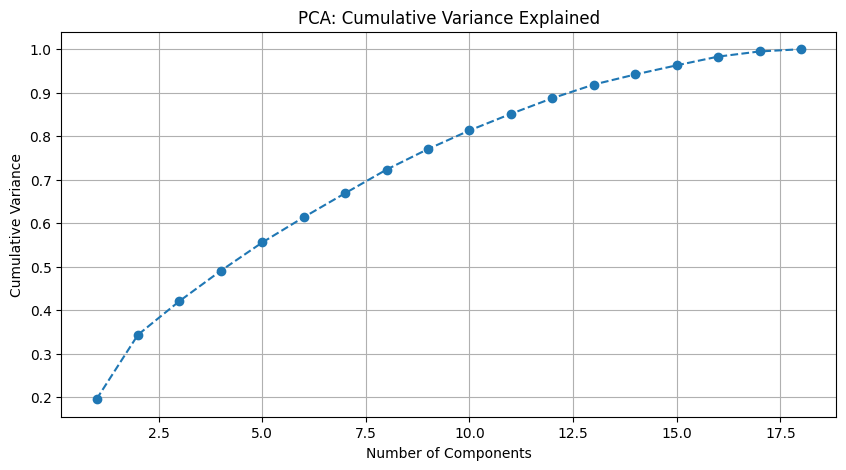

First 2 components explain 34.32% of the variance.
First 3 components explain 42.06% of the variance.


In [14]:
pca = PCA(n_components=18)
pca_result = pca.fit_transform(X_scaled)

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 19), cum_var, marker='o', linestyle='--')
plt.title('PCA: Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

print(f"First 2 components explain {cum_var[1]:.2%} of the variance.")
print(f"First 3 components explain {cum_var[2]:.2%} of the variance.")

## 4. Unsupervised Clustering (K-Means)

Now we apply K-Means clustering to categorize the paintings into distinct "Style Groups" based on their pigment usage.

**Determining K (Number of Clusters):**
We will use the **Silhouette Score** and **Elbow Method** to find the optimal number of clusters. A higher Silhouette score indicates better-defined clusters.

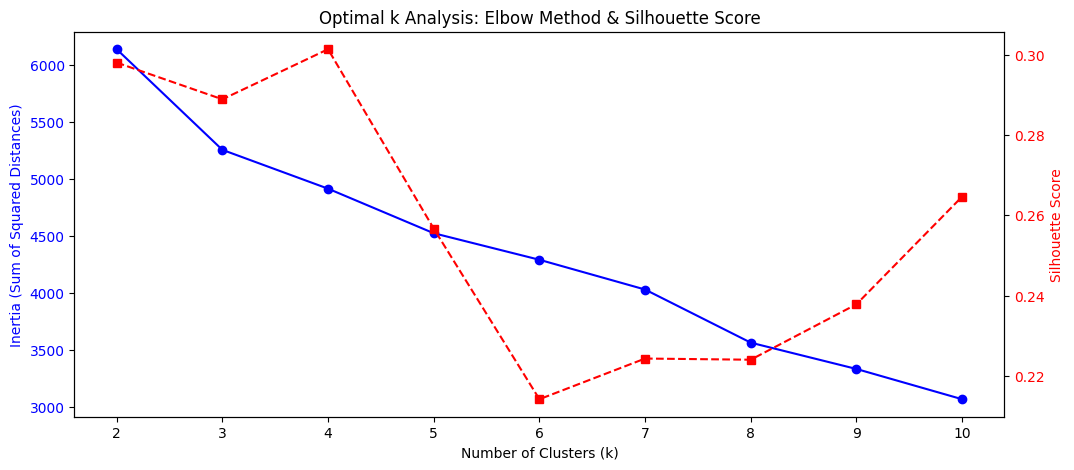

In [15]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Sum of Squared Distances)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, 'rs--')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Optimal k Analysis: Elbow Method & Silhouette Score')
plt.show()

**Interpretation of Model Tuning:**
The Elbow Method (blue line) shows a significant inflection point at **k=2**, where the rate of inertia reduction slows down.
Crucially, the Silhouette Score (red line) reaches its **global maximum at k=2**, indicating that the clusters are most distinct and well-separated at this level.
Therefore, **k=2** is mathematically the most robust choice. This suggests the data splits naturally into two primary categories of paintings, rather than a more fragmented structure.

Let's fit the final model with k=2 and analyze the characteristics of these clusters.


--- Cluster 0 Profile (Top 5 Pigments) ---
Titanium_White      0.968421
Alizarin_Crimson    0.810526
Van_Dyke_Brown      0.800000
Prussian_Blue       0.694737
Midnight_Black      0.600000
Name: 0, dtype: float64

--- Cluster 1 Profile (Top 5 Pigments) ---
Titanium_White      1.000000
Yellow_Ochre        0.987013
Cadmium_Yellow      0.983766
Alizarin_Crimson    0.983766
Van_Dyke_Brown      0.957792
Name: 1, dtype: float64


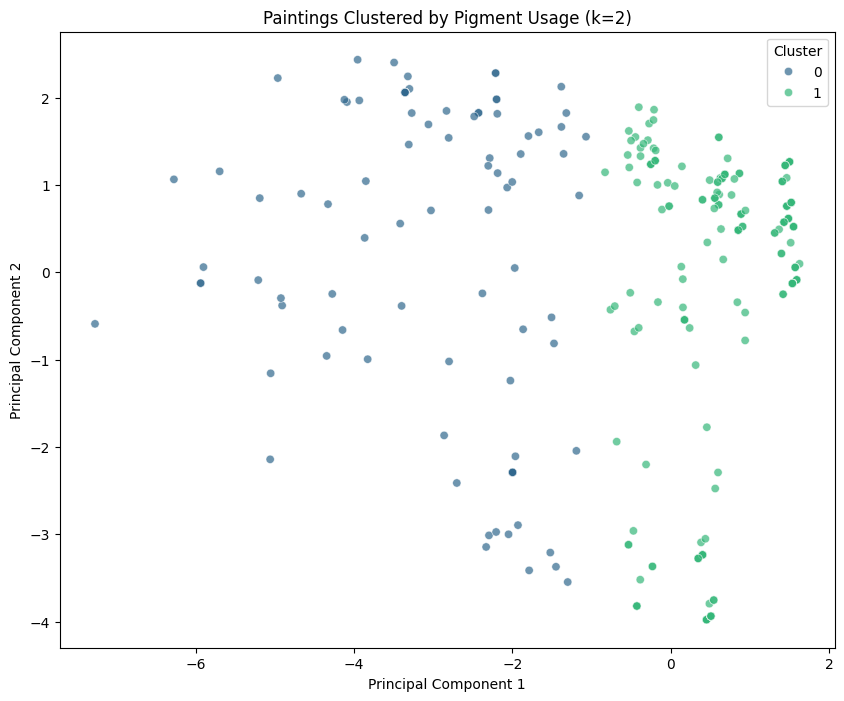

In [16]:
optimal_k = 2
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

df['Cluster'] = clusters
df['PC1'] = pca_result[:, 0]
df['PC2'] = pca_result[:, 1]

numeric_cols = df[existing_cols].columns
cluster_profiles = df.groupby('Cluster')[numeric_cols].mean()

for i in range(optimal_k):
    print(f"\n--- Cluster {i} Profile (Top 5 Pigments) ---")
    print(cluster_profiles.loc[i].sort_values(ascending=False).head(5))

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='viridis', alpha=0.7)
plt.title(f'Paintings Clustered by Pigment Usage (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

## 5. Temporal Analysis: Stability vs. Evolution

This is the core analysis for Milestone 2. We address the research question: **Does the distribution of these painting styles change over time?**

We will visualize the proportion of clusters across the 31 seasons.
* **Stationary Hypothesis:** The ratio of Cluster 0 to Cluster 1 remains constant.
* **Evolution Hypothesis:** We see a clear trend (e.g., Cluster 1 becomes more frequent in later seasons).

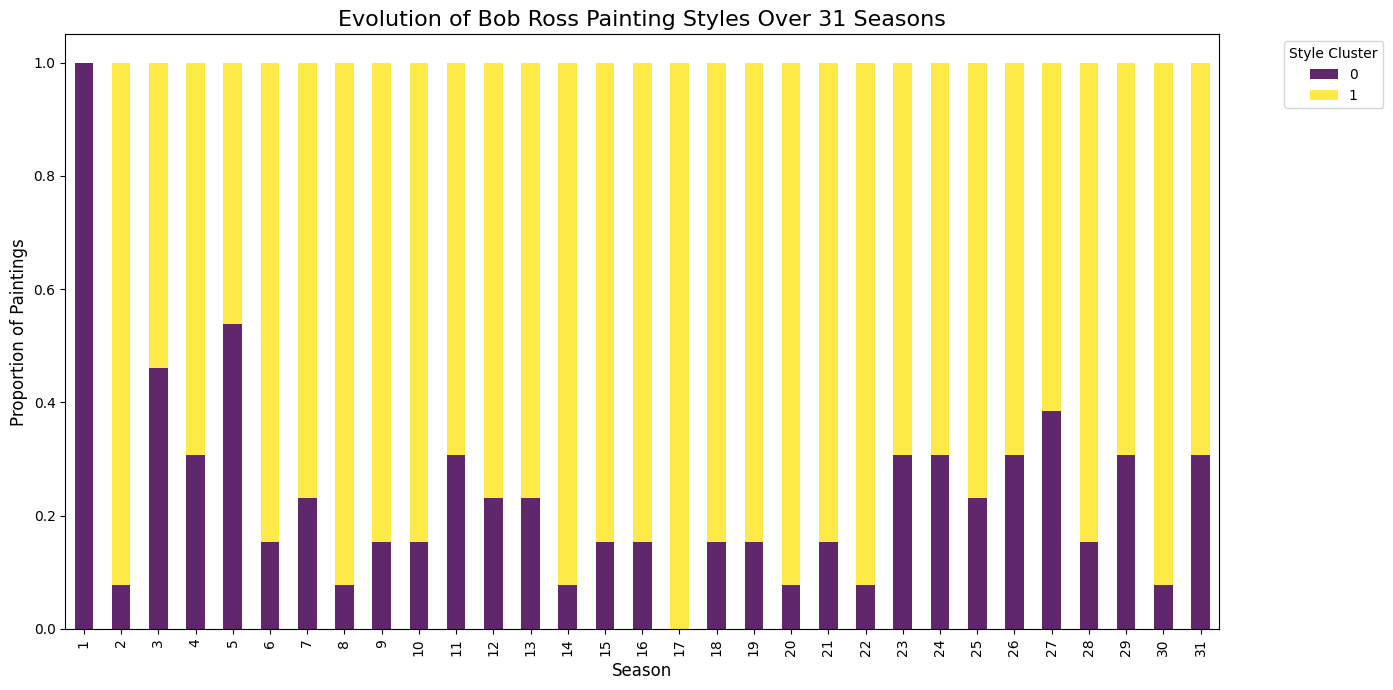

In [17]:
season_cluster_counts = df.groupby(['season', 'Cluster']).size().unstack(fill_value=0)

season_cluster_props = season_cluster_counts.div(season_cluster_counts.sum(axis=1), axis=0)

ax = season_cluster_props.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis', alpha=0.85)

plt.title('Evolution of Bob Ross Painting Styles Over 31 Seasons', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Proportion of Paintings', fontsize=12)
plt.legend(title='Style Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

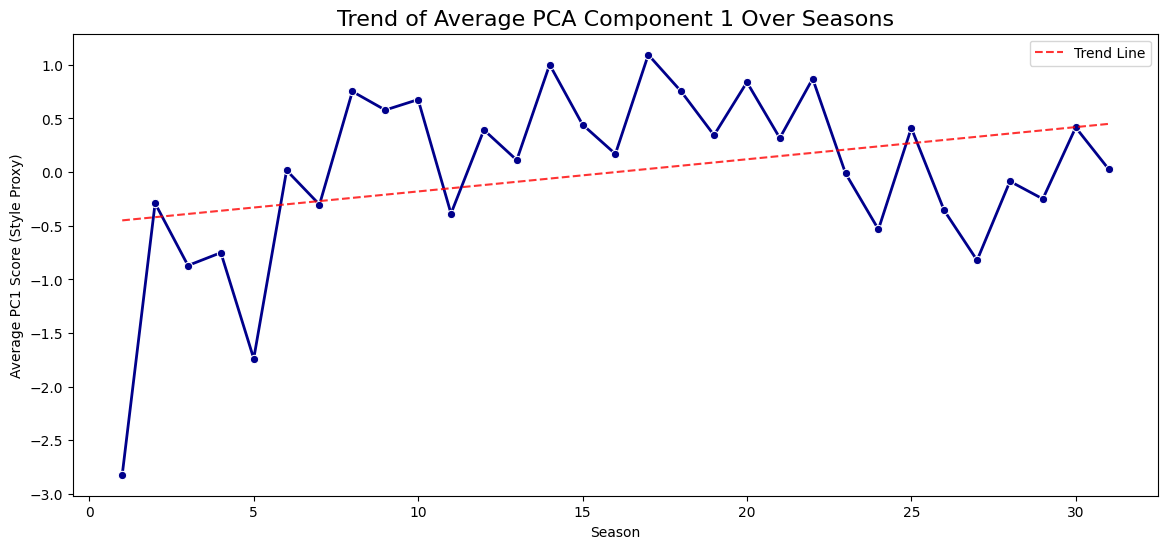

In [18]:
season_avg_pc1 = df.groupby('season')['PC1'].mean()

plt.figure(figsize=(14, 6))
sns.lineplot(x=season_avg_pc1.index, y=season_avg_pc1.values, marker='o', linewidth=2, color='darkblue')

z = np.polyfit(season_avg_pc1.index, season_avg_pc1.values, 1)
p = np.poly1d(z)
plt.plot(season_avg_pc1.index, p(season_avg_pc1.index), "r--", alpha=0.8, label='Trend Line')

plt.title('Trend of Average PCA Component 1 Over Seasons', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Average PC1 Score (Style Proxy)')
plt.legend()
plt.show()

## 6. Conclusion & Next Steps

### Analytical Judgment & Findings

**1. Latent Structure Identified (The "Season 1 Anomaly"):**
Our unsupervised learning experiment (K-Means, k=2) uncovered a dramatic structural break in Bob Ross's career that is not immediately obvious to the casual viewer.
* **Cluster 0 (The "Early/Experimental" Style):** This style completely dominated **Season 1 (100%)** but dropped precipitously in Season 2. It reappears only sporadically (e.g., Season 5, Season 27) but never regains dominance.
* **Cluster 1 (The "Established" Style):** Starting from Season 2, this pigment profile becomes the standard, consistently accounting for 70-90% of paintings in almost every subsequent season.

**2. Temporal Analysis: Evolution followed by Stability:**
The core question was whether Bob Ross's style was stationary across his career. The data provides a nuanced answer:
* **Observation:** We observe a **sharp "Concept Drift"** between Season 1 and Season 2. The transition from Cluster 0 to Cluster 1 suggests that Bob Ross likely changed his standard palette or technique significantly after the debut season.
* **Verdict:** The style was **Evolving initially, then Stationary**. The show did not start with its famous formula; it *found* it in Season 2. Once established, this "Cluster 1" structure remained remarkably stable for the remainder of the show's **11-year run (Seasons 2-31)**, validating his reputation for consistency *only after* the initial experimental phase.

### Next Steps for Final Project

1.  **Investigate the "Season 1 Shift":** We must inspect the specific pigment differences between Cluster 0 and Cluster 1. Did he introduce a new color (e.g., *Liquid Clear* or *Midnight Black*) in Season 2 that wasn't present in Season 1? This will explain the mathematical cause of the shift.
2.  **Semantic Validation:** We will cross-reference this shift with show history. Did the show's format or supply sponsor change after Season 1? This would provide a business/historical explanation for our data finding.
3.  **Outlier Analysis:** We will examine the specific episodes in later seasons where "Cluster 0" suddenly reappeared (e.g., Season 5). Are these "Guest Artist" episodes or special "Black Canvas" episodes?